# Handle missing values in Categorical Features
In this notebook will be shown how to deal with categorical features with missing values.
It will be used the [Classified Ads for Cars](https://www.kaggle.com/mirosval/personal-cars-classifieds) dataset to predict the price of ADs through a simple model of Linear Regression. 

In order to show the various strategies and relevants pros / cons, we will focus on a particular categorical feature of this dataset, the **maker**, the name of the brand of cars (Toyota, Kia, Ford, Bmw, ...). 

We will cover the following techniques:
* **Replace** missing values with the *most frequent values*.
* **Delete** rows with null values.
* **Predict** values using a Classifier Algorithm (supervised or unsupervised)


## Steps of this notebook
* **Show Raw Data**: let's see how our dataset looks like.
* **Some Feature Engineering**: data cleaning and extraction of new features.
* **Dealing with missing values in Categorical Features**: we will deal missing values by comparing different techniques.
* **Conclusions**

## Show Raw Data

Importing Libraries

In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

First of all let's see how our dataset looks like

In [2]:
import zipfile

filename = "cars.csv"

with zipfile.ZipFile(filename + ".zip", 'r') as zip_ref:
    zip_ref.extractall("")

dtypes = {
    "maker": str, # brand name
    "model": str,
    "mileage": float, # km
    "manufacture_year": float,
    "engine_displacement": float,
    "engine_power": float,
    "body_type": str, # almost never present
    "color_slug": str, # also almost never present
    "stk_year": str,
    "transmission": str, # automatic or manual
    "door_count": str,
    "seat_count": str,
    "fuel_type": str, # gasoline or diesel
    "date_created": str, # when the ad was scraped
    "date_last_seen": str, # when the ad was last seen
    "price_eur": float} # list price converted to EUR

df = pd.read_csv(filename, dtype=dtypes)
print(f"Raw data has {df.shape[0]} rows, and {df.shape[1]} columns")
df.head()

Raw data has 3552912 rows, and 16 columns


,maker,model,mileage,manufacture_year,engine_displacement,engine_power,body_type,color_slug,stk_year,transmission,door_count,seat_count,fuel_type,date_created,date_last_seen,price_eur
0,ford,galaxy,151000.0,2011.0,2000.0,103.0,NaN,NaN,None,man,5,7,diesel,2015-11-14 18:10:06.838319+00,2016-01-27 20:40:15.46361+00,10584.75
1,skoda,octavia,143476.0,2012.0,2000.0,81.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.853411+00,2016-01-27 20:40:15.46361+00,8882.31
2,bmw,NaN,97676.0,2010.0,1995.0,85.0,NaN,NaN,None,man,5,5,diesel,2015-11-14 18:10:06.861792+00,2016-01-27 20:40:15.46361+00,12065.06
3,skoda,fabia,111970.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.872313+00,2016-01-27 20:40:15.46361+00,2960.77
4,skoda,fabia,128886.0,2004.0,1200.0,47.0,NaN,NaN,None,man,5,5,gasoline,2015-11-14 18:10:06.880335+00,2016-01-27 20:40:15.46361+00,2738.71


It seems this dataset is chock full of missing values... here we can see how many and in which features 

In [3]:
# Tons of missing values
print(df.isna().sum())

maker                   518915
model                  1133361
mileage                 362584
manufacture_year        370578
engine_displacement     743414
engine_power            554877
body_type              1122914
color_slug             3343411
stk_year               1708156
transmission            741630
door_count              614373
seat_count              749489
fuel_type              1847606
date_created                 0
date_last_seen               0
price_eur                    0
dtype: int64


Now let's look at the values of our data. Some are really unusual. A car with an engine power of 32k or 1 doesn't make much sense... or like a car with 1 million mileage, a price of a few cents, etc ...

In [4]:
# Here we can see strage data, like the Min() and the Max() of some features
df.describe().apply(lambda s: s.apply(lambda x: format(x, 'g')))

,mileage,manufacture_year,engine_displacement,engine_power,price_eur
count,3.19033e+06,3.18233e+06,2.8095e+06,2.99804e+06,3.55291e+06
mean,115814,2000.87,2043.96,98.468,1.62581e+06
std,342251,81.7259,1973.96,49.0731,2.02562e+09
min,0,0,0,1,0.04
25%,18800,2004,1400,68,1295.34
50%,86415,2009,1798,86,7364.91
75%,158025,2013,1997,110,16284.2
max,1e+07,2017,32767,2237,2.70615e+12


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3552912 entries, 0 to 3552911
Data columns (total 16 columns):
maker                  object
model                  object
mileage                float64
manufacture_year       float64
engine_displacement    float64
engine_power           float64
body_type              object
color_slug             object
stk_year               object
transmission           object
door_count             object
seat_count             object
fuel_type              object
date_created           object
date_last_seen         object
price_eur              float64
dtypes: float64(5), object(11)
memory usage: 433.7+ MB


As previously said, missing values are not the only problem. This dataset presents various "unexpected" data. Let's take a quick look at, for example, **seat_count**, **door_count** or **stk_year**. Below here are shown. Due to certain values or their lack, certain features are unlikely to be useful for our purposes.

In [6]:
df = df[df["price_eur"] != 1295.34]
df = df[df["price_eur"] > 150.00]

df_ = df.select_dtypes(exclude=['int', 'float'])
df_ = df_[['maker', 'seat_count', 'door_count', 'stk_year', 'transmission', 'fuel_type']]
for col in df_.columns:
    print("Col: ", col)
    print(df_[col].unique(), end='\n\n') # to print categories name only
    # print(df_[col].value_counts()) # to print count of every category

Col:  maker
['ford' 'skoda' 'bmw' nan 'suzuki' 'nissan' 'opel' 'citroen' 'seat' 'kia'
 'audi' 'rover' 'toyota' 'hyundai' 'fiat' 'volvo' 'chevrolet' 'mazda'
 'jeep' 'mercedes-benz' 'subaru' 'chrysler' 'lancia' 'smart' 'honda'
 'porsche' 'dodge' 'mitsubishi' 'mini' 'jaguar' 'lexus' 'hummer' 'bentley'
 'tesla' 'maserati' 'isuzu' 'lamborghini' 'lotus' 'volkswagen' 'peugeot'
 'renault' 'alfa-romeo' 'infinity' 'rolls-royce' 'aston-martin']

Col:  seat_count
['7' '5' '4' 'None' '6' '9' '8' '2' '3' '1' '18' '20' '10' '11' '15' '12'
 '16' '14' '50' '17' '74' '65' '19' '54' '13' '27' '45' '24' '56' '22'
 '255' '23' '57' '25' nan '51' '55' '61' '21' '53' '26' '58' '30' '36' '0']

Col:  door_count
['5' '3' '4' 'None' '2' '6' '1' '7' nan '9' '8' '77' '58' '54' '0']

Col:  stk_year
['None' '2017' '2016' '2015' '2018' '2107' '3000' '6800' '7900' '9500'
 '7990' '7732' '7201' '5900' '7761' '2019' '2500' '7762' '7257' '2680'
 '3600' '7375' '4000' '2100' '7765' '2101' '8000' '8200' '4500' '9000'
 '2200' 

## Some Feature Engineering
Let's start to fill the numerous missing data of our dataset. The technique that I have decided to implement here is to calculate the average/mode value of the data grouped by some features (maker, model, manufacture_year), and then fill the missing values with the calculated data

In [7]:
# Manufacture Year
min_year = 1970 # minimum threshold of the year. Lower values will be replaced with the average of manufacture_year
average_years = df.loc[df["manufacture_year"] >= min_year].\
groupby(["maker", "model"])["manufacture_year"].\
mean().round().rename("avg_manufacture_year").reset_index() # support column with the average year grouped by maker and model

df = df.merge(average_years, how="left", on=["maker", "model"]) # merge of the support column with the dataframe
df.loc[df["manufacture_year"] < min_year, "manufacture_year"] = np.nan # force values below the minimum threshold to nan
df["manufacture_year"] = df["manufacture_year"].fillna(df["avg_manufacture_year"]) # fill nan values with the average year
df = df[df['manufacture_year'].notna()] # delete of those rows that have not manufacture_year valorized yet

# Engine Power
min_engine_power = 50
average = df.loc[df["engine_power"] >= min_engine_power].\
groupby(["maker", "model", "manufacture_year"])["engine_power"].mean().round().rename("avg_engine_power").reset_index()

df = df.merge(average, how="left", on=["maker", "model", "manufacture_year"])
df.loc[df["engine_power"] < min_engine_power, "engine_power"] = np.nan
df["engine_power"] = df["engine_power"].fillna(df["avg_engine_power"])
df = df[df['engine_power'].notna()]

# Engine Displacement
min_engine_displacement = 600
average = df.loc[df["engine_displacement"] >= min_engine_displacement].\
groupby(["maker", "model"])["engine_displacement"].mean().round().rename("avg_engine_displacement").reset_index()

df = df.merge(average, how="left", on=["maker", "model"])
df.loc[df["engine_displacement"] < min_engine_displacement, "engine_displacement"] = np.nan
df["engine_displacement"] = df["engine_displacement"].fillna(df["avg_engine_displacement"])
df = df[df['engine_displacement'].notna()]

# Mileage
average = df.groupby(["manufacture_year"])["mileage"].mean().\
round().rename("avg_mileage").reset_index() # support column with the average mileage with same manufacture_year

df = df.merge(average, how="left", on=["manufacture_year"]) # merge of the support column with the dataframe
df["mileage"] = df["mileage"].fillna(df["avg_mileage"]) # fill nan values with the average mileage

# Fuel Type
average = df.loc[df["fuel_type"].notna()].\
groupby(["maker","model"])["fuel_type"].agg(lambda x:x.value_counts().index[0]).\
rename("mode_fuel_type").reset_index() # support column with the most frequent value of fuel_type grouped by maker and model

df = df.merge(average, how="left", on=["maker","model"]) # merge of the support column with the dataframe
# df.loc[df["fuel_type"].isna(), "fuel_type"] = np.nan
df["fuel_type"] = df["fuel_type"].fillna(df["mode_fuel_type"]) # fill nan values with the mode of fuel_type
df = df[df['fuel_type'].notna()] # delete of those rows that have not fuel_type valorized yet

df = pd.get_dummies(df,columns=["fuel_type"]) # get dummies variables of this categorical feature 

Here we transform the dates features from string to datetime and then create a new feature called **ad_duration**, calculated as the distance in days between the two dates. This new feature will allow us to understand how tempting the AD is.

In [8]:
# AD duration
df['date_created'] = pd.to_datetime(df['date_created']).dt.normalize()
df['date_last_seen'] = pd.to_datetime(df['date_last_seen']).dt.normalize()
df['ad_duration'] = (df['date_last_seen'] - df['date_created']).dt.days # new feature: how much last the ad

As already mentioned, the **seat_count** feature presents very unexpected data. We then replace the missing values with the median and then create a new categorical feature

In [9]:
features_to_fillna = ["seat_count"]
for feature in features_to_fillna:
    df[feature] = pd.to_numeric(df[feature], errors="coerce") # transform to numeric
    replace_with = df[feature].median()                       # deduction of the median
    df[feature].fillna(replace_with,inplace=True)             # replace null
    
df["seat_str"] = np.select(
    condlist=[
        (df["seat_count"] >= 0) & (df["seat_count"] < 4),
        (df["seat_count"] >= 4) & (df["seat_count"] < 6),
        (df["seat_count"] >= 6)],
    choicelist=[
        "small",
        "medium",
        "large",
        ],
    default="unknown")
df = pd.get_dummies(df,columns=["seat_str"])
df = df.drop(["seat_count"], axis=1)

With the **transmission** feature a few data is missing, so we can *Delete* rows with null values. With the remaining rows we can create two new binary columns starting from the initial categorical feature.

In [10]:
df = df[df['transmission'].notna()]
df = pd.get_dummies(df,columns=["transmission"])
#size_mapping = {"man":0,"auto":1}
#df["transmission"] = df["transmission"].map(size_mapping)

*Drop* support columns and unusable features

In [11]:
# drop features
features_to_drop = ["model", "door_count", "body_type", "color_slug", "stk_year", "avg_manufacture_year", "date_created", "date_last_seen", "avg_engine_displacement","avg_engine_power","avg_mileage", "mode_fuel_type"]
df = df.drop(features_to_drop, axis="columns")

Now that we've cleaned all the features, with the exception of the **maker**, let's see how they look like

In [12]:
# Missing values
print(df.isna().sum())

maker                  212897
mileage                     0
manufacture_year            0
engine_displacement         0
engine_power                0
price_eur                   0
fuel_type_diesel            0
fuel_type_gasoline          0
ad_duration                 0
seat_str_large              0
seat_str_medium             0
seat_str_small              0
transmission_auto           0
transmission_man            0
dtype: int64


<AxesSubplot:>

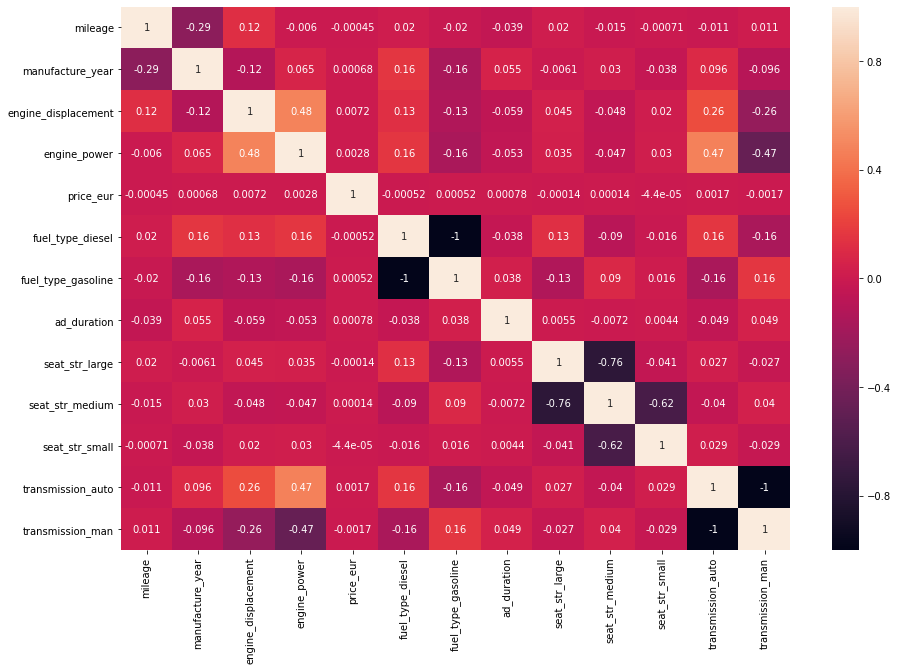

In [13]:
corr = df.corr()
plt.subplots(figsize=(15,10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, )

## Dealing with missing values in Categorical Features
Almost there! Now we just have to handle the **maker** feature, and we will do it with four different ways. Then, for each of them, we will create a simple model of Linear Regression for the prediction of the price.

* **1st Model**: Delete the entire column **maker**.
* **2nd Model**: Replace missing values with the *most frequent values*.
* **3rd Model**: Delete rows with null values.
* **4th Model**: Predict the missing values with the RandomForestClassifier.

In [14]:
mse_list = []
r2_score_list = []

def remove_outliers(dataframe):
    '''
    return a dataframe without rows that are outliers in any column
    '''
    return dataframe\
    .loc[:, lambda df: df.std() > 0.04]\
    .loc[lambda df: (np.abs(stats.zscore(df)) < 3).all(axis=1)]

def plot_regression(Y_test, Y_pred):
    '''
    method that plot a linear regression line on a scatter plot
    '''
    x = Y_test
    y = Y_pred

    plt.xlabel("True label")
    plt.ylabel("Predicted label")
    plt.plot(x, y, 'o')

    m, b = np.polyfit(x, y, 1)

    plt.plot(x, m*x + b)

## Delete the entire column *Maker*
Our first basic try will be to create a model without the column **maker**. This "no-deal" practice is needed when the large amount of missing data threatens to invalidate the entire feature.

With this scenario we will probably have the worst scores on metrics. We will use them to compare the other methods.

In [15]:
df_no_maker = df.copy()

# drop of the maker feature 
df_no_maker = df_no_maker.drop("maker", axis="columns")

df_no_maker = remove_outliers(df_no_maker)

X = df_no_maker.drop("price_eur", axis=1).values
Y = np.log1p(df_no_maker["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))

MSE: 0.13840370565313231
R2 score: 0.8401538102788418


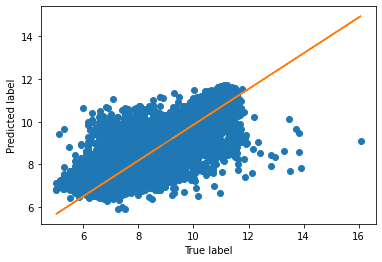

In [16]:
plot_regression(Y_test, Y_pred)

This is our first try. Can we do better?

## Replace missing values with the most frequent data
A certainly more effective method is to assign the missing values with the most frequent data, the mode. But be careful that this could lead to an unbalanced dataset, in case the missing values are a considerable number.

In [17]:
df_replace_mode = df.copy()

replace_with = df_replace_mode["maker"].mode()             # deduction of the mode
df_replace_mode["maker"].fillna(replace_with,inplace=True) # replace null with the mode

df_replace_mode = pd.get_dummies(df_replace_mode,columns=["maker"])

df_replace_mode = remove_outliers(df_replace_mode)

X = df_replace_mode.drop("price_eur", axis=1).values
Y = np.log1p(df_replace_mode["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))

MSE: 0.10243504754361979
R2 score: 0.8703379824571595


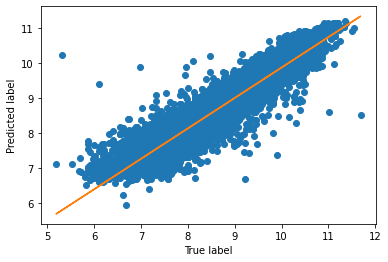

In [18]:
plot_regression(Y_test, Y_pred)

As expected, we got better scoring metrics than before

## Delete rows with null values
Another option is to delete rows that have null values. Absolutely not recommended if our dataset is very small, but easily feasible if there are missing only a few values or if we have a very large dataset


In [19]:
df_del_rows = df.copy()

# deleteing row with null maker
df_del_rows = df_del_rows[df_del_rows['maker'].notna()]
df_del_rows = pd.get_dummies(df_del_rows,columns=["maker"])

df_del_rows = remove_outliers(df_del_rows)

X = df_del_rows.drop("price_eur", axis=1).values
Y = np.log1p(df_del_rows["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))

MSE: 0.10465841311348424
R2 score: 0.8580395349902117


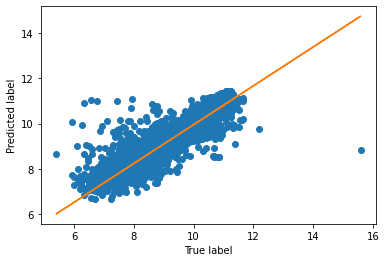

In [20]:
plot_regression(Y_test, Y_pred)

## Predict the missing values with the RandomForestClassifier
The most interesting approach is for sure the predicting of missing values with a classification algorithm. This will give us the opportunity not to waste a good chunk of the dataset, and thus a large amount of information. If our predictions are accurate enough with this technique we should have the best metric scores.

Therefore:
- we have to split the dataset between rows with the column *maker* valorized, and rows with null values.
- the first dataframe will become the one on which we will create the classification model with the *maker* as target feature.
- use the model thus created to predict the missing values from the dataframe with null values
- merge the two dataframe into one
- training the linear regression model

Let's divide the dataset in two

In [21]:
df_with_maker = df[df['maker'].notna()]
print("N. rows with maker not null:", df_with_maker.shape[0])

df_no_maker = df[df['maker'].isna()]
print("N. rows with maker null:", df_no_maker.shape[0])

N. rows with maker not null: 1690186
N. rows with maker null: 212897


Let's start by creating the classification model and take a look at its metrics

ACCURACY: TRAIN=0.9423 TEST=0.8958
LOG LOSS: 0.3404174931299863


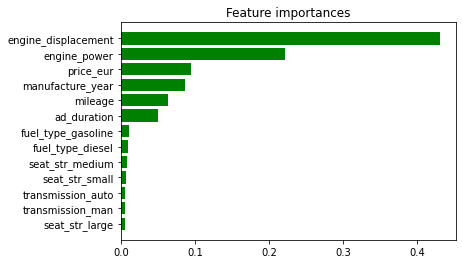

In [22]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score

X = df_with_maker.drop("maker", axis=1).values
Y = df_with_maker["maker"].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=0)

forest = RandomForestClassifier(n_estimators=45, max_depth=25, random_state=False, 
                                max_features=0.6, min_samples_leaf=3, n_jobs=-1)

forest.fit(X_train, Y_train)

y_pred_train = forest.predict(X_train)
y_pred = forest.predict(X_test)

y_pred_proba = forest.predict_proba(X_test)

accuracy_train = accuracy_score(Y_train, y_pred_train)
accuracy_test = accuracy_score(Y_test, y_pred)

print("ACCURACY: TRAIN=%.4f TEST=%.4f" % (accuracy_train,accuracy_test))
print("LOG LOSS: "+str(log_loss(Y_test, y_pred_proba)))

importances = forest.feature_importances_
indices = list(np.argsort(importances))[::-1]

plt.title("Feature importances")
plt.barh(range(len(indices)), importances[indices], color="g", align="center")
plt.yticks(range(len(indices)), df_with_maker.iloc[:, 1:].columns[indices])
# plt.ylim([-1, len(indices)])
plt.gca().invert_yaxis()

Without too much surprise the model tells us that **engine_displacement** and **engine_power** are the key features to determine the **maker**

Now that we have the model, let's fill the 2nd dataframe with the values of the prediction...

In [23]:
df_no_maker = df_no_maker.drop('maker', axis=1)
prediction = forest.predict(df_no_maker)

df_no_maker.insert(0, 'maker', prediction)

...and then, merge the two dataframe togheter

In [24]:
frames = [df_with_maker, df_no_maker]
df_final = pd.concat(frames)
print(df_final.shape[0])

1903083


Here's our final dataframe

In [25]:
df_final.head()

,maker,mileage,manufacture_year,engine_displacement,engine_power,price_eur,fuel_type_diesel,fuel_type_gasoline,ad_duration,seat_str_large,seat_str_medium,seat_str_small,transmission_auto,transmission_man
0,ford,151000.0,2011.0,2000.0,103.0,10584.75,1,0,74,1,0,0,0,1
1,skoda,143476.0,2012.0,2000.0,81.0,8882.31,1,0,74,0,1,0,0,1
2,bmw,97676.0,2010.0,1995.0,85.0,12065.06,1,0,74,0,1,0,0,1
3,skoda,111970.0,2004.0,1200.0,63.0,2960.77,0,1,74,0,1,0,0,1
4,skoda,128886.0,2004.0,1200.0,63.0,2738.71,0,1,74,0,1,0,0,1


Now that our final dataset is ready we can re-create the linear regression model and check if we have improved its metrics

In [26]:
df_final = pd.get_dummies(df_final,columns=["maker"])

df_final = remove_outliers(df_final)

X = df_final.drop("price_eur", axis=1).values
Y = np.log1p(df_final["price_eur"].values)

X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size=0.1, random_state=0)

ll = LinearRegression()
ll.fit(X_train, Y_train)
Y_pred = ll.predict(X_test)

mse_list.append(mean_squared_error(Y_test, Y_pred))
r2_score_list.append(r2_score(Y_test, Y_pred))

print("MSE: "+str(mean_squared_error(Y_test, Y_pred)))
print("R2 score: "+str(r2_score(Y_test, Y_pred)))

MSE: 0.08733466361312969
R2 score: 0.8848236873451352


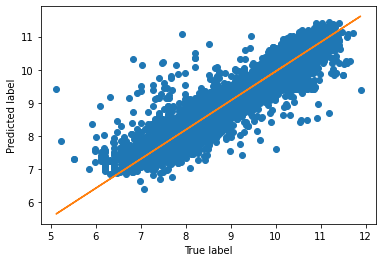

In [27]:
plot_regression(Y_test, Y_pred)

Here's we can see the best metrics values thanks to the rows saved through the aforementioned dataset merge

## Conclusions
Our considerations are driven by metrics. Deleting the feature from the dataset should be our last resort. Replacing null data with the most frequent ones or deleting the rows can be a convenient solution in case we have few missing data or a very large dataset. On the contrary, in case we have a lot of missing values or a small dataset, a prediction/clustering could save us valuable information that would otherwise be lost.

In [28]:
options_list = [
    "Delete the entire column Maker", 
    "Replace null values with the mode", 
    "Delete rows with null values", 
    "Predict the missing values"
]

df_metrics = pd.DataFrame({
    "": options_list,
    "MSE": mse_list,
    "R2_score": r2_score_list,
})
df_metrics.head()

,,MSE,R2_score
0,Delete the entire column Maker,0.138404,0.840154
1,Replace null values with the mode,0.102435,0.870338
2,Delete rows with null values,0.104658,0.858040
3,Predict the missing values,0.087335,0.884824
